In [87]:
## IMPORT NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Bidirectional
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2

In [88]:
## READING THE DATA AND CONVERTING IT INTO A DATAFRAME
uploaded = files.upload()

Saving Microsoft Dataset.csv to Microsoft Dataset (4).csv


In [89]:
## CONVERTING THE DATA INTO DATAFRAME
df = pd.read_csv('Microsoft Dataset.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400


In [90]:
### SELECTING THE ADJUSTED CLOSING PRICES FOR TIME SERIES
df = df.iloc[:,[0,5]]

df.head()

,Date,Adj Close
0,1986-03-13,0.060055
1,1986-03-14,0.062199
2,1986-03-17,0.063272
3,1986-03-18,0.061663
4,1986-03-19,0.060591


In [91]:
### CONVERTING DATE COLUMN TO DATETIME FORMAT AND SETTING IT AS INDEX
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

<ipython-input-91-a813889e3714>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


,Adj Close
Date,
1986-03-13,0.060055
1986-03-14,0.062199
1986-03-17,0.063272
1986-03-18,0.061663
1986-03-19,0.060591


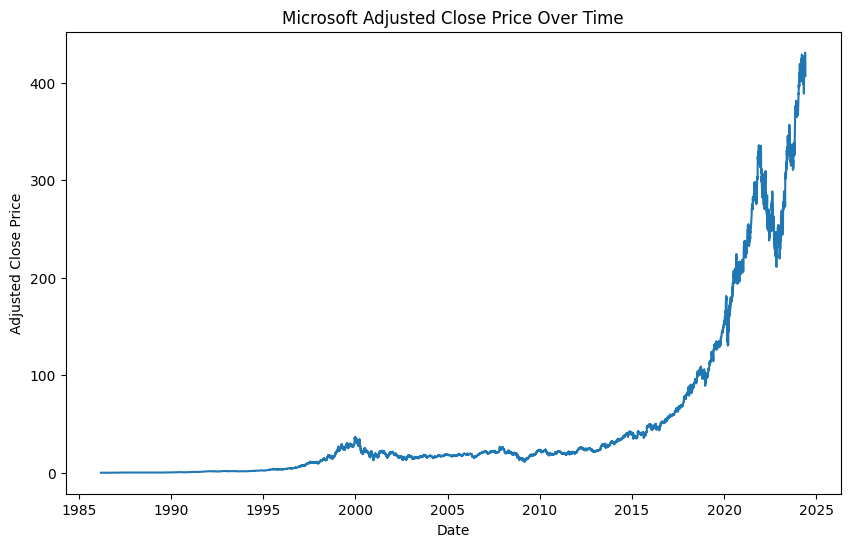

In [92]:
### PLOTTING THE ADJUSTED CLOSING PRICE
plt.figure(figsize=(10, 6))
plt.plot(df['Adj Close'])
plt.title('Microsoft Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

In [93]:
## CONVERTING THE DATAFRAME TO A NUMPY ARRAY
input = df.values
print(input)

print(len(input))


[[6.00550000e-02]
 [6.21990000e-02]
 [6.32720000e-02]
 ...
 [4.29170013e+02]
 [4.14670013e+02]
 [4.06760010e+02]]
9632


In [94]:
## DECIDING THE TRAINING AND TEST SIZE OF DATA AND FINALLY SLICING OF THE DATA

split_percent = 0.8
tr_size = int(split_percent*len(input))
train = input[:tr_size]
test = input[tr_size:]

print(train.shape)

print(test.shape)

(7705, 1)
(1927, 1)


In [95]:
### NORMALIZING THE TRAIN AND TEST DATA BETWEEN 0 AND 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [96]:
## CREATION OF THE SEQUENCED DATA SETS FOR TRAINING AND TESTING
step = 4
train_data = TimeseriesGenerator(train_scaled, train_scaled, length = step, batch_size = 1)
test_data = TimeseriesGenerator(test_scaled, test_scaled, length = step, batch_size = 1)
train_data[0]  ## 1st input and its output from train set


(array([[[8.17021129e-05],
         [1.22534125e-04],
         [1.42969175e-04],
         [1.12326122e-04]]]),
 array([[9.19101158e-05]]))

In [97]:
test_data[0]  ## 1st input and its output in test set

(array([[[0.9839957 ],
         [0.99087936],
         [0.99260002],
         [0.99363222]]]),
 array([[0.99776289]]))

In [98]:
## CONSTRUCTION OF THE SIMPLE RECURRENT NEURAL NETWORK
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(step, train_scaled.shape[1])))
model.add(Dense(1))  ## Output layer (1 unit for prediction)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
## MODEL COMPILATION AND FITTING
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7701/7701 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 3.4281e-04 - mae: 0.0091 - val_loss: 0.0051 - val_mae: 0.0471
Epoch 2/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 9.2674e-05 - mae: 0.0066 - val_loss: 0.0122 - val_mae: 0.0837
Epoch 3/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 9.0755e-05 - mae: 0.0064 - val_loss: 0.0160 - val_mae: 0.0937
Epoch 4/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 9.3124e-05 - mae: 0.0064 - val_loss: 0.0129 - val_mae: 0.0791
Epoch 5/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 8.4688e-05 - mae: 0.0061 - val_loss: 0.0057 - val_mae: 0.0550


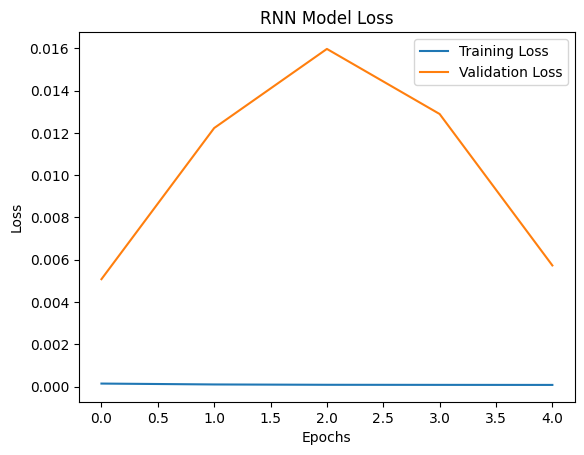

In [100]:
### PLOTTING TRAINING HISTORY
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [101]:
## INLINE PREDICTION FROM THE NETWORK
yr_pred_train = model.predict(train_data)
yr_pred_train

7701/7701 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


array([[-1.06900930e-04],
       [-1.09657645e-04],
       [-1.12265348e-04],
       ...,
       [ 1.02563477e+00],
       [ 1.00765634e+00],
       [ 1.01492047e+00]], dtype=float32)

In [102]:
## TEST DATA PREDICTION
yr_pred_test = model.predict(test_data)
yr_pred_test

1923/1923 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


array([[1.018083 ],
       [1.0234885],
       [1.0067443],
       ...,
       [8.19033  ],
       [8.150275 ],
       [7.880928 ]], dtype=float32)

In [103]:
### RESCALING THE PREDICTIONS AND ACTUAL VALUES TO THEIR ORIGINAL SCALE
train_pred_rescaled = scaler.inverse_transform(yr_pred_train)
test_pred_rescaled = scaler.inverse_transform(yr_pred_test)


train_actual_rescaled = scaler.inverse_transform(train_scaled[step:])
test_actual_rescaled = scaler.inverse_transform(test_scaled[step:])


In [104]:
### SIMPLE RNN EVALUATION
mse_rnn = mean_squared_error(test_actual_rescaled, test_pred_rescaled)
mae_rnn = mean_absolute_error(test_actual_rescaled, test_pred_rescaled)

print('RNN MEAN SQUARED ERROR', mse_rnn)
print('RNN MEAN ABSOLUTE ERROR', mae_rnn)


RNN MEAN SQUARED ERROR 15.805049906563392
RNN MEAN ABSOLUTE ERROR 2.8889368380470377


In [105]:
### IMPLEMENTING LSTM AND CONSTRUCTING LSTM RNN
model = Sequential()

model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False), input_shape=(step, train_scaled.shape[1])))
model.add(Dense(1))  ## Output layer with 1 unit (since we're predicting a single value)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,901 (81.64 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
### MODEL COMPILING AND TRAINING
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0041 - mae: 0.0198 - val_loss: 23.0026 - val_mae: 3.2133
Epoch 2/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 1.6355e-04 - mae: 0.0089 - val_loss: 4.8370 - val_mae: 1.5247
Epoch 3/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - loss: 1.3812e-04 - mae: 0.0080 - val_loss: 0.1257 - val_mae: 0.2541
Epoch 4/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - loss: 1.1305e-04 - mae: 0.0071 - val_loss: 0.0880 - val_mae: 0.2024
Epoch 5/5
7701/7701 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - loss: 9.6677e-05 - mae: 0.0067 - val_loss: 0.2162 - val_mae: 0.2937


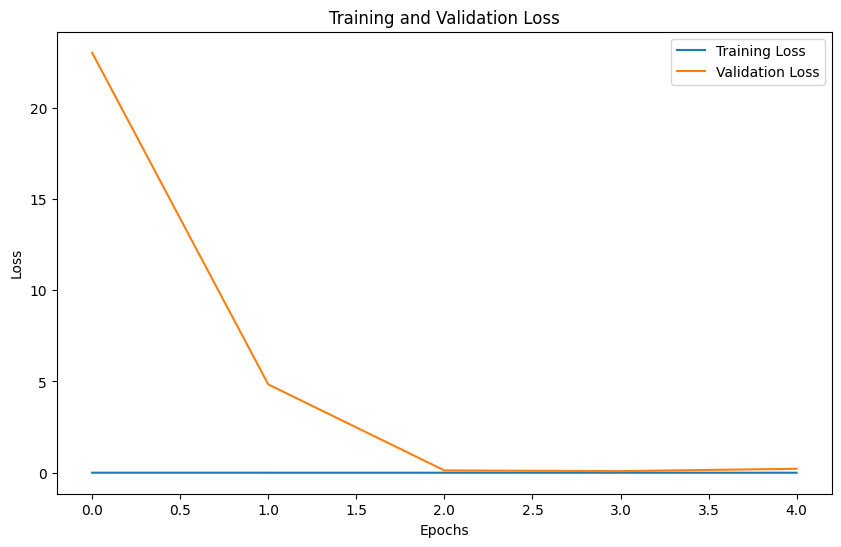

In [107]:
### PLOTTING THE TRAINING HISTORY
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
### INLINE PREDICTION
train_pred = model.predict(train_data)
train_pred

7701/7701 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


array([[-0.00107422],
       [-0.00107885],
       [-0.00109676],
       ...,
       [ 0.98971283],
       [ 0.97929054],
       [ 0.9843854 ]], dtype=float32)

In [109]:
### TEST DATA PREDICTION
test_pred = model.predict(test_data)
test_pred

1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


array([[0.9863665],
       [0.9907963],
       [0.9765945],
       ...,
       [9.617542 ],
       [9.595783 ],
       [9.208403 ]], dtype=float32)

In [110]:
### RESCALING THE PREDICTIONS AND ACTUAL TEST
train_pred_rescaled = scaler.inverse_transform(train_pred)
test_pred_rescaled = scaler.inverse_transform(test_pred)



In [111]:
### BIDIRECTIONAL LSTM EVALUATION
mse_test = mean_squared_error(test_actual_rescaled, test_pred_rescaled)
mae_test = mean_absolute_error(test_actual_rescaled, test_pred_rescaled)

print('BIDIRECTIONAL LSTM MEAN SQUARED ERROR', mse_test)
print('BIDIRECTIONAL LSTM MEAN ABSOLUTE ERROR', mae_test)


BIDIRECTIONAL LSTM MEAN SQUARED ERROR 596.0097412639562
BIDIRECTIONAL LSTM MEAN ABSOLUTE ERROR 15.421076241751527
